In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install wordcloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
mh_reddit = pd.read_csv('/content/drive/MyDrive/Dissertation Datasets/Datasets/Reddit/MHData_Reddit.csv')
mh_twitter = pd.read_csv('/content/drive/MyDrive/Dissertation Datasets/Datasets/Twitter/MHData_Twitter.csv')

In [ ]:
mh_reddit.head()

title  score       id  \
0           r/MentalHealth is looking for moderators      6  1e297nd   
1                         Politics and Mental Health     13  1e1m1i1   
2                        Is my friend being groomed?    111  1e7xgrs   
3                                 I hate being a man    138  1e7prs0   
4  Why do people casually diagnose others with me...     12  1e7yfyr   

                                                 url  comms_num       created  \
0  https://www.reddit.com/r/mentalhealth/comments...          0  1.720874e+09   
1  https://www.reddit.com/r/mentalhealth/comments...          4  1.720802e+09   
2  https://www.reddit.com/r/mentalhealth/comments...         38  1.721487e+09   
3  https://www.reddit.com/r/mentalhealth/comments...         58  1.721459e+09   
4  https://www.reddit.com/r/mentalhealth/comments...          6  1.721490e+09   

                                                body  
0  Hey r/mentalhealth! We're looking to grow our ...  
1  Hello friends!\n\nThe team has noticed an incr...  
2  My friend, whos 15 this year, has a ballet tea...  
3  I hate being a boy so fucking much.\n\nI'm gay...  
4  Im geniunely annoyed and this is kinda of a ra...

In [ ]:
mh_reddit.shape

(21365, 7)

In [ ]:
mh_twitter.head()

user_id           created_at  \
0  7.865930e+17  02/23/2020 03:10:21   
1  7.865930e+17  02/22/2020 00:54:18   
2  2.811850e+07  02/23/2020 02:35:49   
3  2.811850e+07  02/23/2020 03:10:14   
4  1.175070e+18  02/23/2020 03:10:12   

                                                text  
0  @katiecouric We're hoping you can do for #lung...  
1  @katiecouric We're hoping you can do for #lung...  
2  The scars aren't always visible. The pain can ...  
3  Find balance.  Failure is ok.  Giving up is no...  
4  <U+0001F64F>\r\n\r\nI Meditate\r\nI Pray\r\nI ...

In [ ]:
mh_twitter.shape

(23005, 3)

Preprocessing

In [ ]:
# Removing duplicates and unnecessary columns

# Twitter Data
mh_twitter_clean = mh_twitter.drop_duplicates(subset='text').drop(columns=['user_id', 'created_at'])

In [ ]:
mh_twitter_clean.shape

(11920, 1)

In [ ]:
mh_twitter_clean.head()

text
0  @katiecouric We're hoping you can do for #lung...
2  The scars aren't always visible. The pain can ...
3  Find balance.  Failure is ok.  Giving up is no...
4  <U+0001F64F>\r\n\r\nI Meditate\r\nI Pray\r\nI ...
5  <U+0001F441><U+FE0F>\r\n\r\nNot all disabiliti...

In [ ]:
# Reddit Data (removing duplicates, dropping irrelevant columns and renaming "body" to "text")
mh_reddit_clean = mh_reddit.drop_duplicates(subset='body')
mh_reddit_clean = mh_reddit_clean.drop(columns=['title', 'score', 'id', 'url', 'comms_num', 'created'])
mh_reddit_clean = mh_reddit_clean.rename(columns={'body': 'text'})

In [ ]:
mh_reddit_clean.shape

(20573, 1)

In [ ]:
mh_reddit_clean.head()

text
0  Hey r/mentalhealth! We're looking to grow our ...
1  Hello friends!\n\nThe team has noticed an incr...
2  My friend, whos 15 this year, has a ballet tea...
3  I hate being a boy so fucking much.\n\nI'm gay...
4  Im geniunely annoyed and this is kinda of a ra...

In [ ]:
# Check for null values in the entire dataset
print(mh_reddit_clean.isnull().sum())


text    1
dtype: int64


In [ ]:
# Check for null values in the entire dataset
print(mh_twitter_clean.isnull().sum())


text    0
dtype: int64


In [ ]:
#removing nulls in mh_reddit_clean
mh_reddit_clean = mh_reddit_clean.dropna()

In [ ]:
print(mh_reddit_clean.isnull().sum())

text    0
dtype: int64


In [ ]:
# Creating and removing custom list of keywords indicating organisational or governmental content
custom_keywords = [
    'awareness', 'gov', 'official', 'ministry', 'our',
    'organization', 'follow', 'donate', 'we need' , 'government',
    'startup', 'contest', 'initiative', 'department', 'movement', 'organize', 'workshop',
    'conference', 'seminar', 'study', 'research', 'services', 'tickets', 'suicideprevention',
    'campus', 'program', 'reports', 'survey', 'statistics', 'industry', 'invited',
    'join', 'series',  'register', 'enroll', 'launching', 'launch'
]

In [ ]:
# Function to check if a row contains any of the custom keywords
def contains_keywords(text, keywords):
    for keyword in keywords:
        if keyword.lower() in text.lower():
            return True
    return False


In [ ]:
# Applying the function to remove rows from Twitter dataset
mh_twitter_clean = mh_twitter_clean[~mh_twitter_clean['text'].apply(lambda x: contains_keywords(x, custom_keywords))]
# Applying the function to remove rows from Reddit dataset
mh_reddit_clean = mh_reddit_clean[~mh_reddit_clean['text'].apply(lambda x: contains_keywords(x, custom_keywords))]


In [ ]:
# Check the results after removing rows
print(f"Twitter data shape after filtering: {mh_twitter_clean.shape}")
print(f"Reddit data shape after filtering: {mh_reddit_clean.shape}")


Twitter data shape after filtering: (6021, 1)
Reddit data shape after filtering: (12330, 1)


In [ ]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back to string
    clean_text = ' '.join(tokens)
    return clean_text

In [ ]:
# Apply preprocessing to Twitter dataset
mh_twitter_clean['clean_text'] = mh_twitter_clean['text'].apply(preprocess_text)

In [ ]:
mh_twitter_clean['clean_text'].shape

(6021,)

In [ ]:
# Apply preprocessing to Reddit dataset
mh_reddit_clean['clean_text'] = mh_reddit_clean['text'].apply(preprocess_text)

In [ ]:
mh_reddit_clean['clean_text'].shape

(12330,)

In [ ]:
# Display a sample of the 'text' column before preprocessing
print("Sample before preprocessing:")
print(mh_twitter_clean['text'].head(5))



Sample before preprocessing:
2    The scars aren't always visible. The pain can ...
4    <U+0001F64F>\r\n\r\nI Meditate\r\nI Pray\r\nI ...
5    <U+0001F441><U+FE0F>\r\n\r\nNot all disabiliti...
7    Inhale peace. Exhale calm. #meditation #thedai...
8    Inner peace leads to higher consciousness. #me...
Name: text, dtype: object


In [ ]:
# Display the sample of 'clean_text' after preprocessing
print("Sample after preprocessing:")
print(mh_twitter_clean['clean_text'].head(5))

Sample after preprocessing:
2    scar arent always visible pain lie within voic...
4    uff meditate pray burn candle drink green tea ...
5    ufufef disability visible may able see schizoa...
7    inhale peace exhale calm meditation thedailyme...
8    inner peace lead higher consciousness meditati...
Name: clean_text, dtype: object


In [ ]:
mh_reddit_clean['clean_text'].shape

(12330,)

In [ ]:
!pip install transformers

In [ ]:
# Annotate data

from transformers import pipeline
import torch

In [ ]:
# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Initialize emotion classification pipeline with GPU support
classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/distilbert-base-uncased-emotion",
    tokenizer="bhadresh-savani/distilbert-base-uncased-emotion",
    truncation=True,
    device=device  # Set device to GPU if available, otherwise use CPU
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def classify_batch(texts):
    # Classify a batch of texts
    results = classifier(texts)
    return [(result['label'], result['score']) for result in results]


In [ ]:
def apply_batch_processing(df, text_column, batch_size=16):
    emotions = []
    scores = []

    for i in range(0, len(df), batch_size):
        batch_texts = df[text_column].iloc[i:i+batch_size].tolist()

        # Handle empty or NaN texts
        batch_texts = [text if pd.notna(text) else "" for text in batch_texts]

        # Classify the batch
        batch_results = classify_batch(batch_texts)

        # Extend lists with batch results
        batch_emotions, batch_scores = zip(*batch_results)
        emotions.extend(batch_emotions)
        scores.extend(batch_scores)

    return pd.DataFrame({'emotion': emotions, 'score': scores})


In [ ]:
# Apply batch processing to Twitter data
mh_twitter_clean[['emotion', 'score']] = apply_batch_processing(mh_twitter_clean, 'clean_text')


In [ ]:
# Apply batch processing to Reddit data
mh_reddit_clean[['emotion', 'score']] = apply_batch_processing(mh_reddit_clean, 'clean_text')

In [ ]:
# Drop rows with NaN target labels in the Twitter and Reddit dataset
mh_twitter_clean = mh_twitter_clean.dropna(subset=['emotion'])
mh_reddit_clean = mh_reddit_clean.dropna(subset=['emotion'])

Exploratory Data Analysis

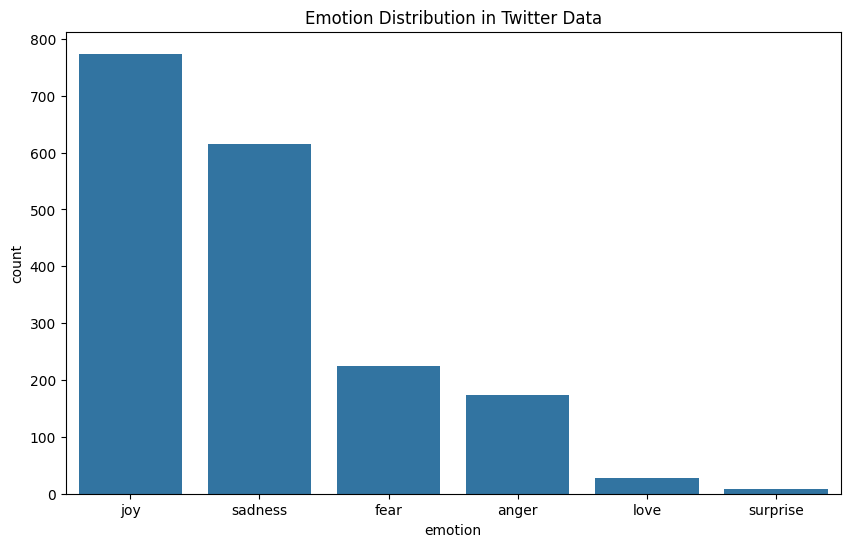

In [ ]:
# Emotion distribution Plot for Twitter data
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=mh_twitter_clean)
plt.title('Emotion Distribution in Twitter Data')
plt.show()


In [ ]:
# Count occurrences of each emotion in the Twitter data
emotion_counts_twitter = mh_twitter_clean['emotion'].value_counts()

# Print the counts for Twitter data
print("Emotion distribution in Twitter data:")
print(emotion_counts_twitter)


Emotion distribution in Twitter data:
emotion
joy         774
sadness     615
fear        225
anger       174
love         28
surprise      8
Name: count, dtype: int64


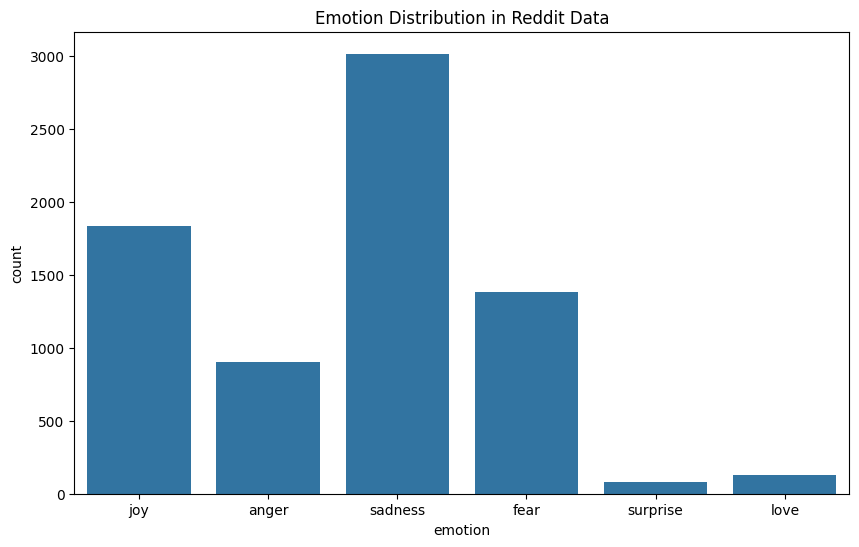

In [ ]:
# Emotion distribution Plot for Reddit data
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=mh_reddit_clean)
plt.title('Emotion Distribution in Reddit Data')
plt.show()

In [ ]:
# Count occurrences of each emotion in the Reddit data (if needed)
emotion_counts_reddit = mh_reddit_clean['emotion'].value_counts()

# Print the counts for Reddit data
print("\nEmotion distribution in Reddit data:")
print(emotion_counts_reddit)


Emotion distribution in Reddit data:
emotion
sadness     3015
joy         1833
fear        1381
anger        900
love         131
surprise      80
Name: count, dtype: int64


In [ ]:
# Text Length Distribution

# Add a column for text length to both datasets
mh_twitter_clean['text_length'] = mh_twitter_clean['clean_text'].apply(len)
mh_reddit_clean['text_length'] = mh_reddit_clean['clean_text'].apply(len)


Text(0, 0.5, 'Frequency')

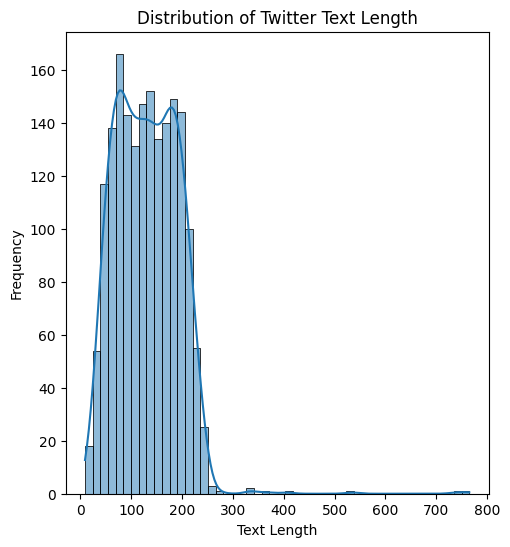

In [ ]:
# Plot text length distribution for Twitter data
plt.figure(figsize=(12, 6))

# Histogram for Twitter data
plt.subplot(1, 2, 1)
sns.histplot(mh_twitter_clean['text_length'], bins=50, kde=True)
plt.title('Distribution of Twitter Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')


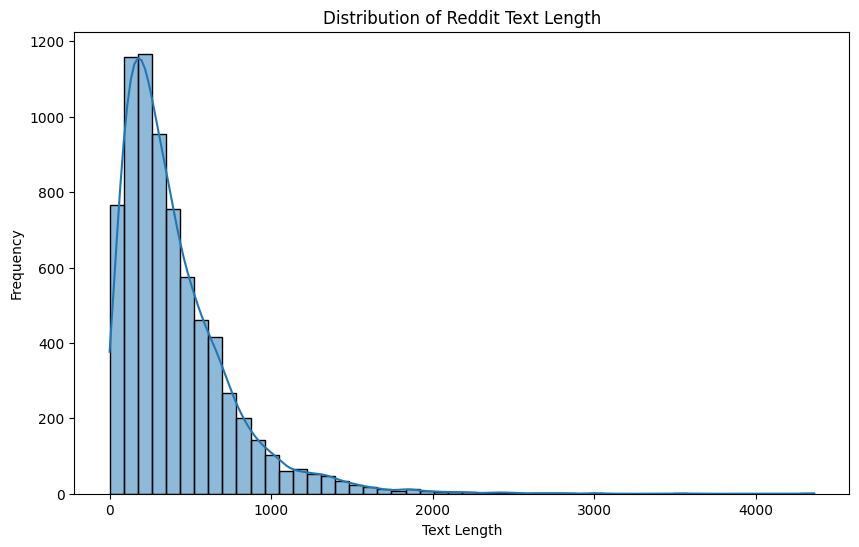

In [ ]:
# Histogram for Reddit data
plt.figure(figsize=(10, 6))
sns.histplot(mh_reddit_clean['text_length'], bins=50, kde=True)
plt.title('Distribution of Reddit Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Find minimum and maximum text lengths for Twitter
min_length_twitter = mh_twitter_clean['text_length'].min()
max_length_twitter = mh_twitter_clean['text_length'].max()

print(f"Twitter Data - Minimum Text Length: {min_length_twitter}")
print(f"Twitter Data - Maximum Text Length: {max_length_twitter}")

Twitter Data - Minimum Text Length: 9
Twitter Data - Maximum Text Length: 765


In [ ]:
# Find minimum and maximum text lengths for Reddit
min_length_reddit = mh_reddit_clean['text_length'].min()
max_length_reddit = mh_reddit_clean['text_length'].max()

print(f"Reddit Data - Minimum Text Length: {min_length_reddit}")
print(f"Reddit Data - Maximum Text Length: {max_length_reddit}")

Reddit Data - Minimum Text Length: 0
Reddit Data - Maximum Text Length: 4363


In [ ]:
# Word counts
# Calculate word count for each post in the 'clean_text' column for both datasets
mh_twitter_clean['word_count'] = mh_twitter_clean['clean_text'].apply(lambda x: len(x.split()))
mh_reddit_clean['word_count'] = mh_reddit_clean['clean_text'].apply(lambda x: len(x.split()))


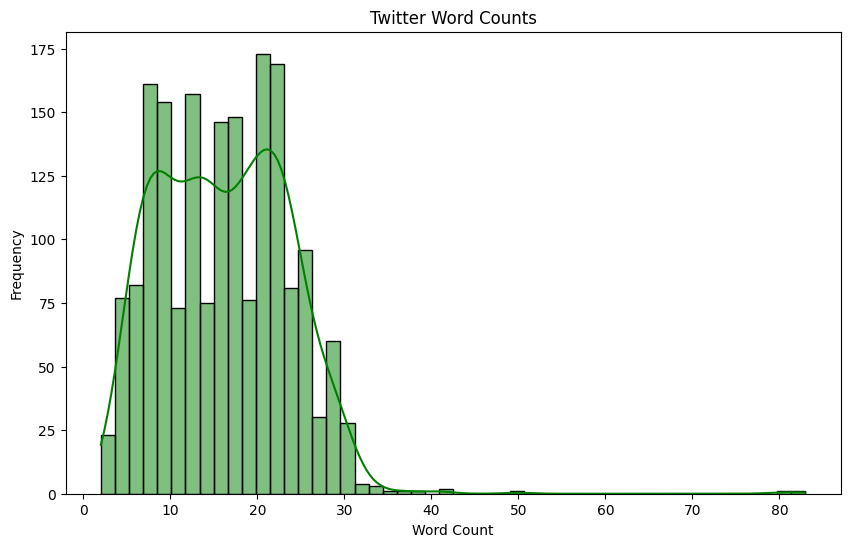

In [ ]:
# Plot histogram for word count for Twitter
plt.figure(figsize=(10, 6))
sns.histplot(mh_twitter_clean['word_count'], bins=50, kde=True, color='green')
plt.title('Twitter Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

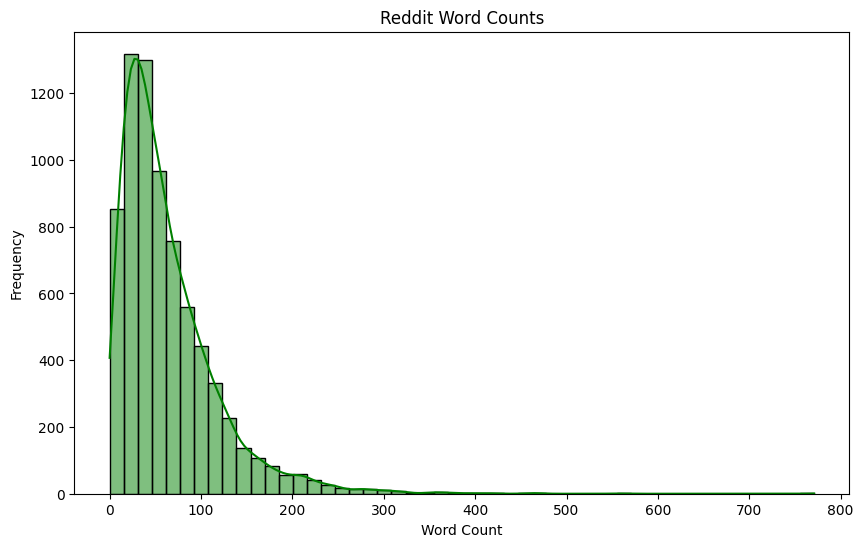

In [ ]:
# Plot histogram for word count for Reddit
plt.figure(figsize=(10, 6))
sns.histplot(mh_reddit_clean['word_count'], bins=50, kde=True, color='green')
plt.title('Reddit Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

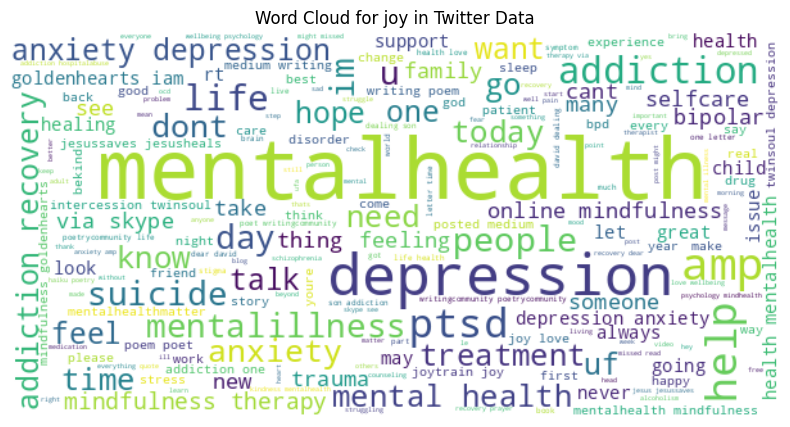

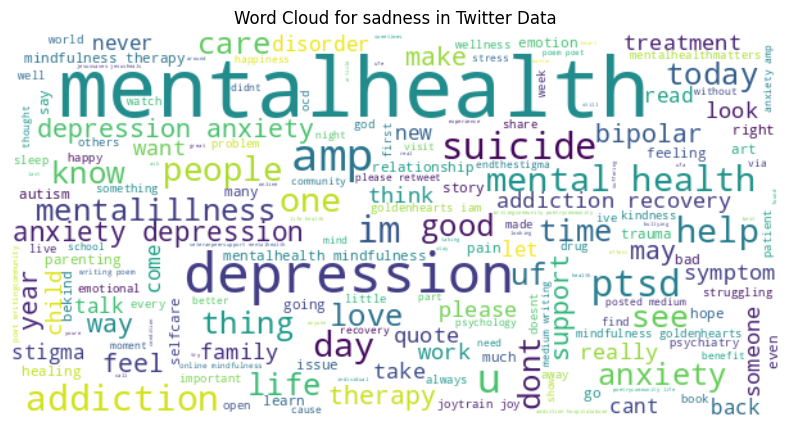

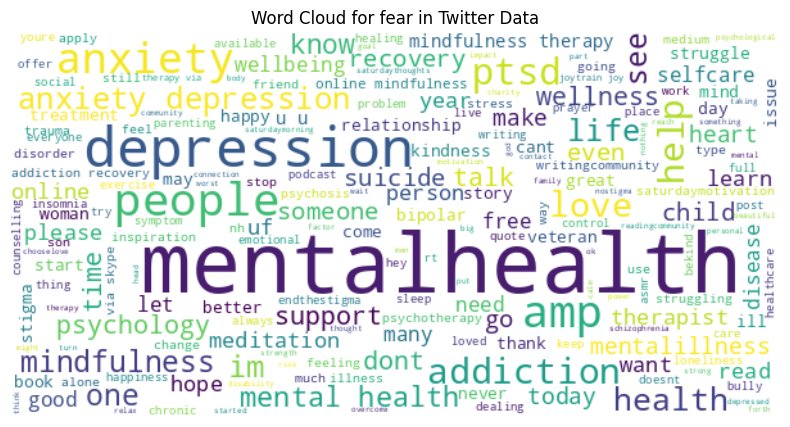

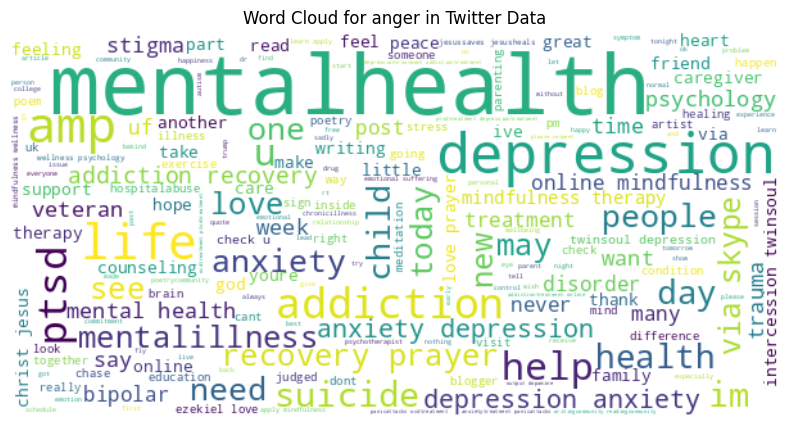

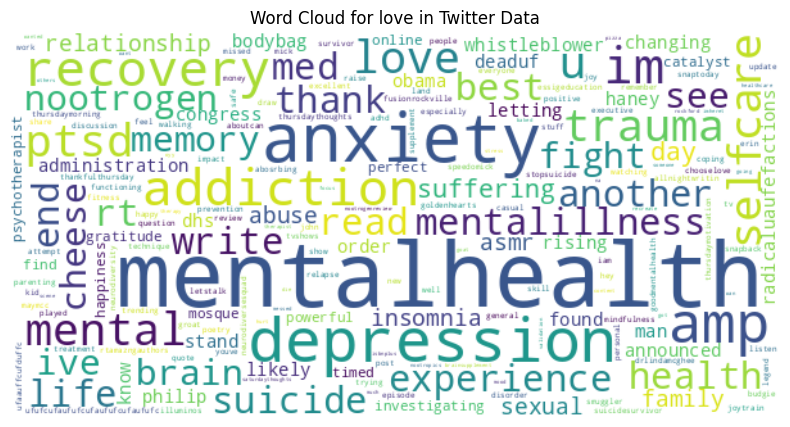

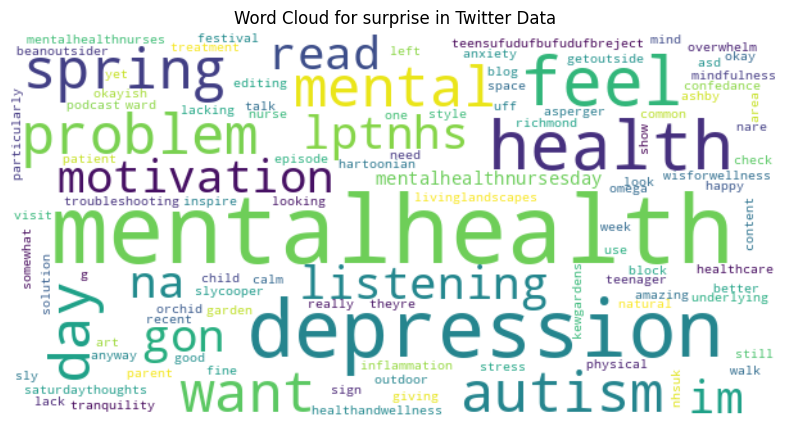

In [ ]:
# List of unique emotions
emotions = mh_twitter_clean['emotion'].unique()

# Generate and plot word clouds for each emotion
for emotion in emotions:
    # Concatenate all texts for the current emotion
    text = ' '.join(mh_twitter_clean[mh_twitter_clean['emotion'] == emotion]['clean_text'])

    # Check if text is not empty
    if text.strip():  # Ensure there is some content
        # Generate the word cloud
        wordcloud = WordCloud(width=600, height=300, background_color='white').generate(text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion} in Twitter Data')
        plt.show()
    else:
        print(f"No text available for emotion: {emotion}")


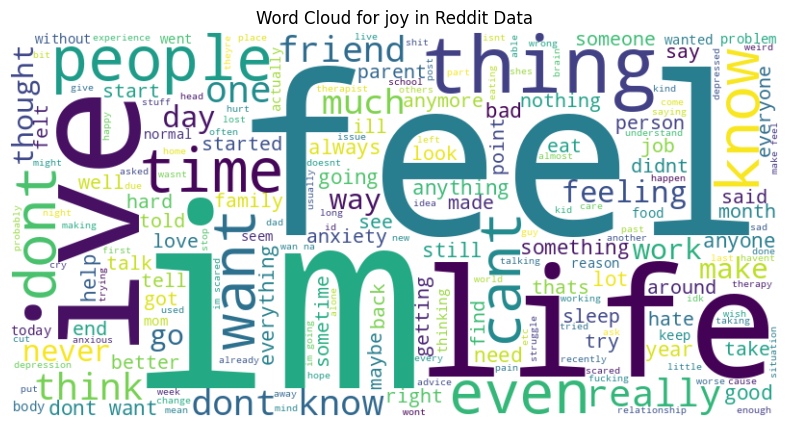

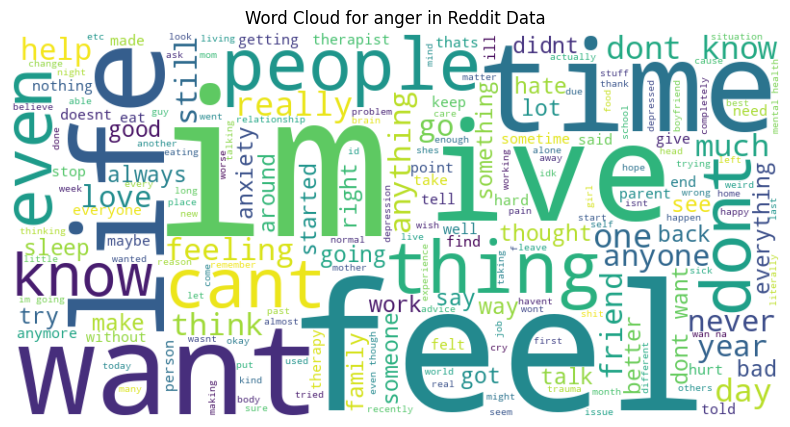

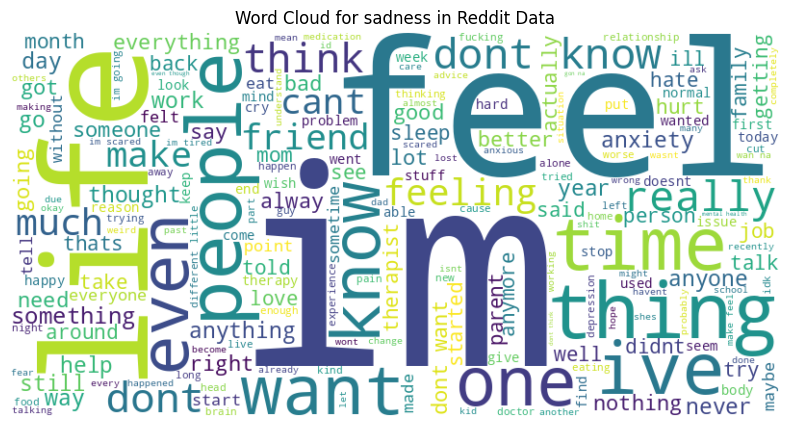

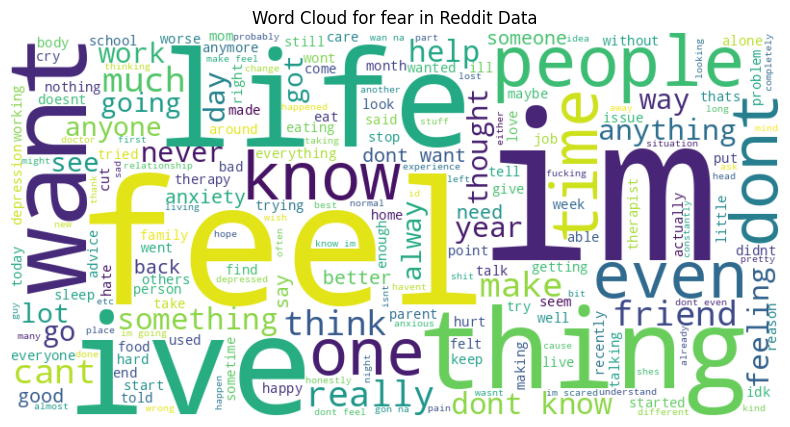

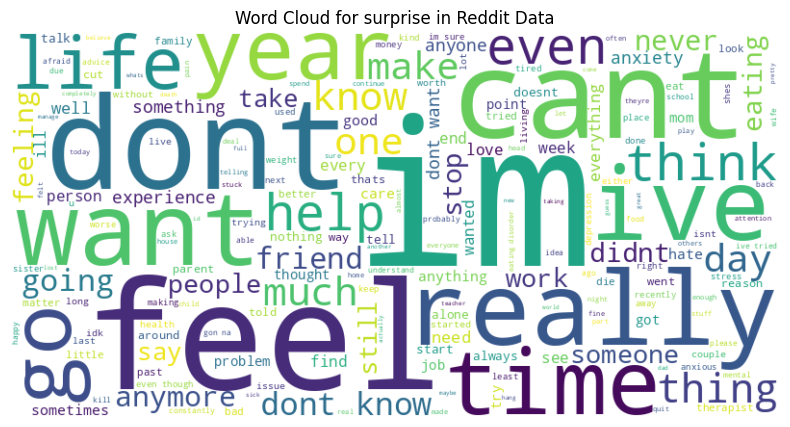

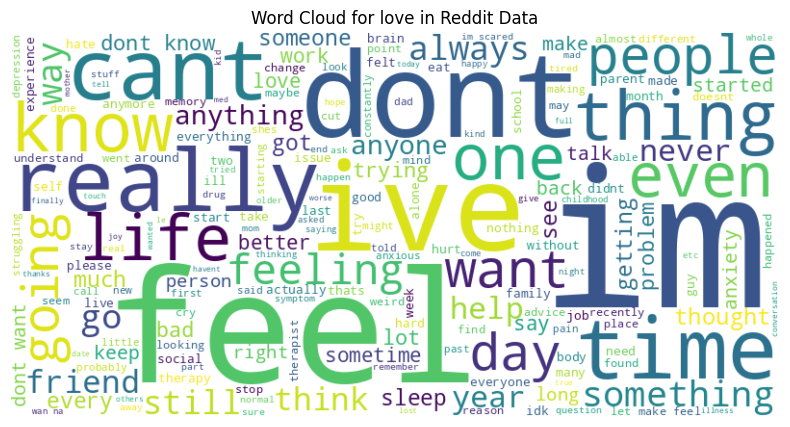

In [ ]:
# List of unique emotions for Reddit
emotions_reddit = mh_reddit_clean['emotion'].unique()

# Generate and plot word clouds for each emotion
for emotion in emotions_reddit:
    # Concatenate all texts for the current emotion
    text = ' '.join(mh_reddit_clean[mh_reddit_clean['emotion'] == emotion]['clean_text'])

    # Check if text is not empty
    if text.strip():  # Ensure there is some content
        # Generate the word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion} in Reddit Data')
        plt.show()
    else:
        print(f"No text available for emotion: {emotion}")


Model training and evaluation

In [ ]:
!pip install imbalanced-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Defining the target labels from the 'emotion' column for Twitter and Reddit
y_twitter = mh_twitter_clean['emotion']
y_reddit = mh_reddit_clean['emotion']

In [ ]:
# Vectorise text data using TF-IDF Vectorization

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
# Fit and transform Twitter and Reddit data
X_twitter = vectorizer.fit_transform(mh_twitter_clean['clean_text'])
X_reddit = vectorizer.fit_transform(mh_reddit_clean['clean_text'])

In [ ]:
# Label encoding

# Initialize the label encoder
label_encoder = LabelEncoder()

# Apply label encoding to Twitter and Reddit target labels (y_twitter) and (y_reddit)
y_twitter_encoded = label_encoder.fit_transform(y_twitter)
y_reddit_encoded = label_encoder.fit_transform(y_reddit)


In [ ]:
# Create a DataFrame that holds the original emotions and their encoded labels for Twitter
twitter_encoded_df = pd.DataFrame({'emotion': y_twitter, 'encoded_emotion': y_twitter_encoded})
# Get the value counts for each class in Twitter
twitter_value_counts = twitter_encoded_df.value_counts(['emotion', 'encoded_emotion']).reset_index(name='count')
print("Twitter Emotion Counts with Encodings:")
print(twitter_value_counts)


Twitter Emotion Counts with Encodings:
    emotion  encoded_emotion  count
0       joy                2    774
1   sadness                4    615
2      fear                1    225
3     anger                0    174
4      love                3     28
5  surprise                5      8


In [ ]:
# Create a DataFrame that holds the original emotions and their encoded labels for Reddit
reddit_encoded_df = pd.DataFrame({'emotion': y_reddit, 'encoded_emotion': y_reddit_encoded})
# Get the value counts for each class in Reddit
reddit_value_counts = reddit_encoded_df.value_counts(['emotion', 'encoded_emotion']).reset_index(name='count')
print("Reddit Emotion Counts with Encodings:")
print(reddit_value_counts)

Reddit Emotion Counts with Encodings:
    emotion  encoded_emotion  count
0   sadness                4   3015
1       joy                2   1833
2      fear                1   1381
3     anger                0    900
4      love                3    131
5  surprise                5     80


In [ ]:
# Split data into training and testing sets
X_twitter_train, X_twitter_test, y_twitter_train, y_twitter_test = train_test_split(
    X_twitter, y_twitter_encoded, test_size=0.2, random_state=42)

X_reddit_train, X_reddit_test, y_reddit_train, y_reddit_test = train_test_split(
    X_reddit, y_reddit_encoded, test_size=0.2, random_state=42)

In [ ]:
# Oversampling the minority classes (only on training data)
# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply random oversampling to the Twitter training data
X_twitter_train_resampled, y_twitter_train_resampled = ros.fit_resample(X_twitter_train, y_twitter_train)

# Apply random oversampling to the Reddit training data
X_reddit_train_resampled, y_reddit_train_resampled = ros.fit_resample(X_reddit_train, y_reddit_train)

In [ ]:
# Count the number of samples in each class for Twitter data before oversampling
class_counts_twitter_before = np.bincount(y_twitter_encoded)
print("Twitter data class distribution before oversampling:", class_counts_twitter_before)

# Count the number of samples in each class for Reddit data before oversampling
class_counts_reddit_before = np.bincount(y_reddit_encoded)
print("Reddit data class distribution before oversampling:", class_counts_reddit_before)

Twitter data class distribution before oversampling: [174 225 774  28 615   8]
Reddit data class distribution before oversampling: [ 900 1381 1833  131 3015   80]


In [ ]:
# Count the number of samples in each class for Twitter data after oversampling
class_counts_twitter_after = np.bincount(y_twitter_train_resampled)
print("Twitter data class distribution after oversampling:", class_counts_twitter_after)

# Count the number of samples in each class for Reddit data after oversampling
class_counts_reddit_after = np.bincount(y_reddit_train_resampled)
print("Reddit data class distribution after oversampling:", class_counts_reddit_after)


Twitter data class distribution after oversampling: [620 620 620 620 620 620]
Reddit data class distribution after oversampling: [2397 2397 2397 2397 2397 2397]


In [ ]:
# Determine the number of classes
num_classes_twitter = max(len(class_counts_twitter_before), len(class_counts_twitter_after))
num_classes_reddit = max(len(class_counts_reddit_before), len(class_counts_reddit_after))

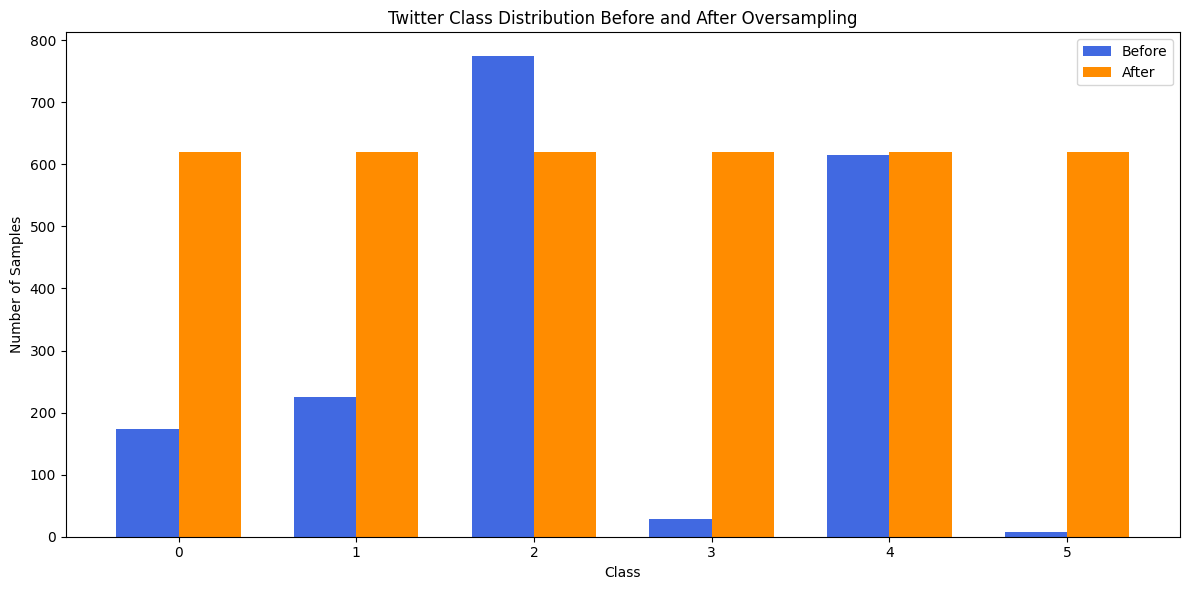

In [ ]:
# Define bar width and index for the plots
bar_width = 0.35
index_twitter = np.arange(num_classes_twitter)

# Plotting Twitter data
plt.figure(figsize=(12, 6))
plt.bar(index_twitter, class_counts_twitter_before, bar_width, color='royalblue', label='Before')
plt.bar(index_twitter + bar_width, class_counts_twitter_after, bar_width, color='orange', label='After')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Twitter Class Distribution Before and After Oversampling')
plt.legend()
plt.xticks(index_twitter + bar_width / 2, range(num_classes_twitter))
plt.tight_layout()
plt.show()

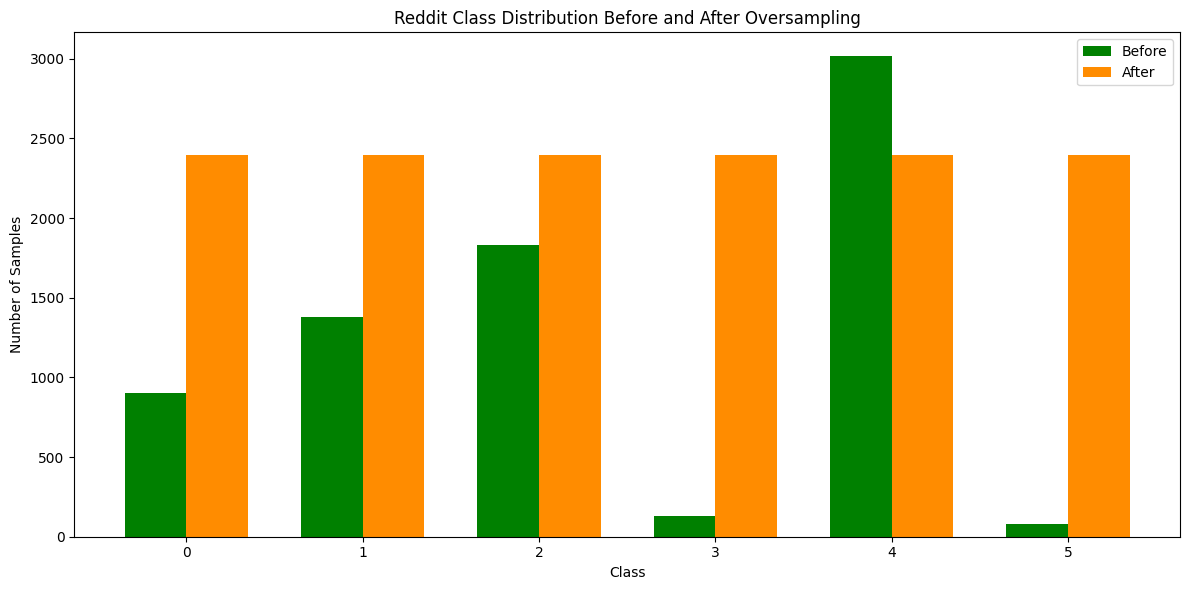

In [ ]:
bar_width = 0.35
index_reddit = np.arange(num_classes_reddit)
# Plotting Reddit data
plt.figure(figsize=(12, 6))
plt.bar(index_reddit, class_counts_reddit_before, bar_width, color='green', label='Before')
plt.bar(index_reddit + bar_width, class_counts_reddit_after, bar_width, color='orange', label='After')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Reddit Class Distribution Before and After Oversampling')
plt.legend()
plt.xticks(index_reddit + bar_width / 2, range(num_classes_reddit))  # Adjust x-ticks for clarity
plt.tight_layout()
plt.show()

In [ ]:
# TRAIN MODELS SEPARATELY
# Train SVM model on resampled Twitter data
svm_model_twitter = SVC(kernel='linear')
svm_model_twitter.fit(X_twitter_train_resampled, y_twitter_train_resampled)

# Evaluate on the original Twitter test set
y_twitter_pred = svm_model_twitter.predict(X_twitter_test)
print("Twitter Model Performance on Test Set:")
print("Accuracy:", accuracy_score(y_twitter_test, y_twitter_pred))
print(classification_report(y_twitter_test, y_twitter_pred))


Twitter Model Performance on Test Set:
Accuracy: 0.35342465753424657
              precision    recall  f1-score   support

           0       0.06      0.03      0.04        30
           1       0.00      0.00      0.00        48
           2       0.39      0.65      0.49       154
           3       0.00      0.00      0.00         2
           4       0.38      0.22      0.28       129
           5       0.00      0.00      0.00         2

    accuracy                           0.35       365
   macro avg       0.14      0.15      0.13       365
weighted avg       0.30      0.35      0.31       365



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Train SVM model on resampled Reddit data
svm_model_reddit = SVC(kernel='linear')
svm_model_reddit.fit(X_reddit_train_resampled, y_reddit_train_resampled)

# Evaluate on the original Reddit test set
y_reddit_pred = svm_model_reddit.predict(X_reddit_test)
print("Reddit Model Performance on Test Set:")
print("Accuracy:", accuracy_score(y_reddit_test, y_reddit_pred))
print(classification_report(y_reddit_test, y_reddit_pred))


Reddit Model Performance on Test Set:
Accuracy: 0.3801089918256131
              precision    recall  f1-score   support

           0       0.08      0.01      0.01       161
           1       0.09      0.02      0.03       299
           2       0.23      0.15      0.18       342
           3       0.00      0.00      0.00        30
           4       0.42      0.81      0.56       618
           5       0.00      0.00      0.00        18

    accuracy                           0.38      1468
   macro avg       0.14      0.16      0.13      1468
weighted avg       0.26      0.38      0.28      1468



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


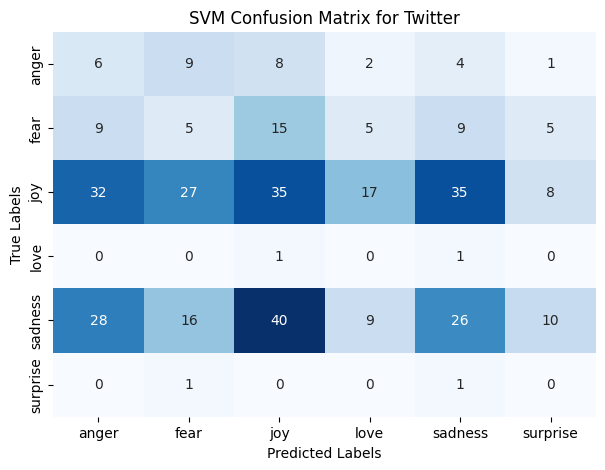

In [ ]:
# Plot SVM Confusion Matrix

# Confusion Matrix for Twitter
# Get the confusion matrix
cm_twitter = confusion_matrix(y_twitter_test, y_twitter_pred)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm_twitter, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix for Twitter')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


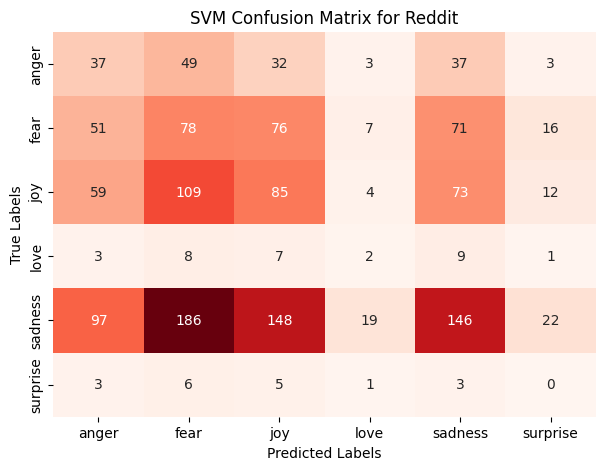

In [ ]:
# SVM Confusion Matrix for Reddit
# Get the confusion matrix
cm_reddit = confusion_matrix(y_reddit_test, y_reddit_pred)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm_reddit, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix for Reddit')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
# Train Naive Bayes model on resampled Twitter data
nb_model_twitter = MultinomialNB()
nb_model_twitter.fit(X_twitter_train_resampled, y_twitter_train_resampled)


MultinomialNB()

In [ ]:
# Evaluate on the original Twitter test set
y_twitter_pred = nb_model_twitter.predict(X_twitter_test)
print("Naive Bayes Model Performance on Twitter Test Set:")
print("Accuracy:", accuracy_score(y_twitter_test, y_twitter_pred))
print(classification_report(y_twitter_test, y_twitter_pred))

Naive Bayes Model Performance on Twitter Test Set:
Accuracy: 0.19726027397260273
              precision    recall  f1-score   support

           0       0.08      0.20      0.11        30
           1       0.09      0.10      0.09        48
           2       0.35      0.23      0.28       154
           3       0.00      0.00      0.00         2
           4       0.34      0.20      0.25       129
           5       0.00      0.00      0.00         2

    accuracy                           0.20       365
   macro avg       0.14      0.12      0.12       365
weighted avg       0.29      0.20      0.23       365



In [ ]:
# Train Naive Bayes model on resampled Reddit data
nb_model_reddit = MultinomialNB()
nb_model_reddit.fit(X_reddit_train_resampled, y_reddit_train_resampled)

# Evaluate on the original Reddit test set
y_reddit_pred = nb_model_reddit.predict(X_reddit_test)
print("Naive Bayes Model Performance on Reddit Test Set:")
print("Accuracy:", accuracy_score(y_reddit_test, y_reddit_pred))
print(classification_report(y_reddit_test, y_reddit_pred))

Naive Bayes Model Performance on Reddit Test Set:
Accuracy: 0.23705722070844687
              precision    recall  f1-score   support

           0       0.15      0.23      0.18       161
           1       0.18      0.26      0.21       299
           2       0.24      0.25      0.24       342
           3       0.06      0.07      0.06        30
           4       0.43      0.24      0.31       618
           5       0.00      0.00      0.00        18

    accuracy                           0.24      1468
   macro avg       0.18      0.17      0.17      1468
weighted avg       0.29      0.24      0.25      1468



In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()


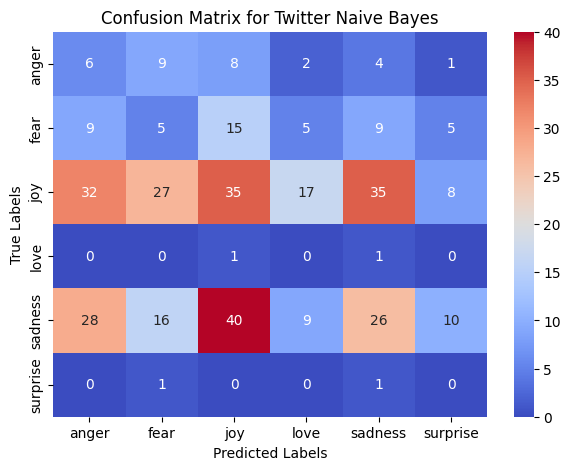

In [ ]:
# Plot confusion matrix for Twitter Naive Bayes
plot_confusion_matrix(y_twitter_test, y_twitter_pred, classes=label_encoder.classes_, title='Confusion Matrix for Twitter Naive Bayes')


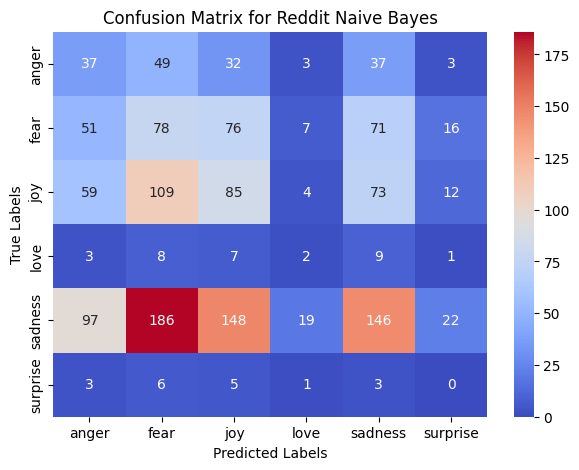

In [ ]:
# Plot confusion matrix for Reddit Naive Bayes
plot_confusion_matrix(y_reddit_test, y_reddit_pred, classes=label_encoder.classes_, title='Confusion Matrix for Reddit Naive Bayes')

In [ ]:
# CROSS-PLATFORM TRAINING

# Fit TF-IDF on Combined Data
# Fit the TfidfVectorizer on the combined text data from both Twitter and Reddit,
# then transform the datasets separately. This will ensure that both datasets have the same features (vocabulary).



In [ ]:
# Combine the text data from both Twitter and Reddit
combined_text = mh_twitter_clean['clean_text'].tolist() + mh_reddit_clean['clean_text'].tolist()


In [ ]:
# Initialize and fit TF-IDF vectorizer on combined text data
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
vectorizer.fit(combined_text)

# Transform Twitter and Reddit text data using the fitted vectorizer
X_twitter_combined = vectorizer.transform(mh_twitter_clean['clean_text'])
X_reddit_combined = vectorizer.transform(mh_reddit_clean['clean_text'])


In [ ]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder on combined labels
combined_labels = mh_twitter_clean['emotion'].tolist() + mh_reddit_clean['emotion'].tolist()
label_encoder.fit(combined_labels)

# Encode Twitter and Reddit labels
y_twitter_encoded = label_encoder.transform(mh_twitter_clean['emotion'])
y_reddit_encoded = label_encoder.transform(mh_reddit_clean['emotion'])


In [ ]:
# Split Twitter and Reddit data into training and testing sets
X_twitter_train, X_twitter_test, y_twitter_train, y_twitter_test = train_test_split(
    X_twitter_combined, y_twitter_encoded, test_size=0.2, random_state=42)

X_reddit_train, X_reddit_test, y_reddit_train, y_reddit_test = train_test_split(
    X_reddit_combined, y_reddit_encoded, test_size=0.2, random_state=42)


In [ ]:
# Step 1: Train on Twitter and Test on Reddit

# Train SVM on Twitter and test on Reddit

svm_model_twitter = SVC(kernel='linear', class_weight='balanced')
svm_model_twitter.fit(X_twitter_train, y_twitter_train)

# Evaluate on Reddit test data
y_reddit_pred = svm_model_twitter.predict(X_reddit_test)
print("SVM Model Performance (Twitter Train, Reddit Test):")
print(classification_report(y_reddit_test, y_reddit_pred, target_names=label_encoder.classes_))



SVM Model Performance (Twitter Train, Reddit Test):
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       161
        fear       0.00      0.00      0.00       299
         joy       0.08      0.00      0.01       342
        love       0.00      0.00      0.00        30
     sadness       0.42      0.99      0.59       618
    surprise       0.00      0.00      0.00        18

    accuracy                           0.42      1468
   macro avg       0.08      0.16      0.10      1468
weighted avg       0.20      0.42      0.25      1468



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Train on Reddit and Test on Twitter

# Train SVM model on Reddit data
svm_model_reddit = SVC(kernel='linear', class_weight='balanced')
svm_model_reddit.fit(X_reddit_train, y_reddit_train)

# Evaluate on Twitter test data
y_twitter_pred = svm_model_reddit.predict(X_twitter_test)
print("SVM Model Performance (Reddit Train, Twitter Test):")
print(classification_report(y_twitter_test, y_twitter_pred, target_names=label_encoder.classes_))


SVM Model Performance (Reddit Train, Twitter Test):
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        30
        fear       0.14      0.06      0.09        48
         joy       0.49      0.12      0.19       154
        love       0.00      0.00      0.00         2
     sadness       0.35      0.83      0.50       129
    surprise       0.00      0.00      0.00         2

    accuracy                           0.35       365
   macro avg       0.16      0.17      0.13       365
weighted avg       0.35      0.35      0.27       365



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


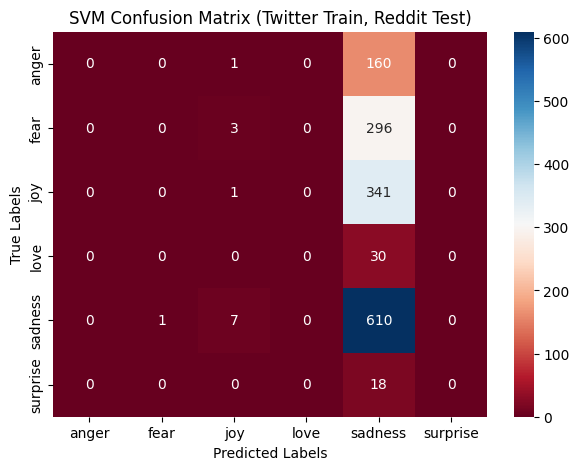

In [ ]:
# Compute confusion matrix for Twitter train and Reddit test
cm_reddit = confusion_matrix(y_reddit_test, y_reddit_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm_reddit, annot=True, fmt='d', cmap='RdBu', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix (Twitter Train, Reddit Test)')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


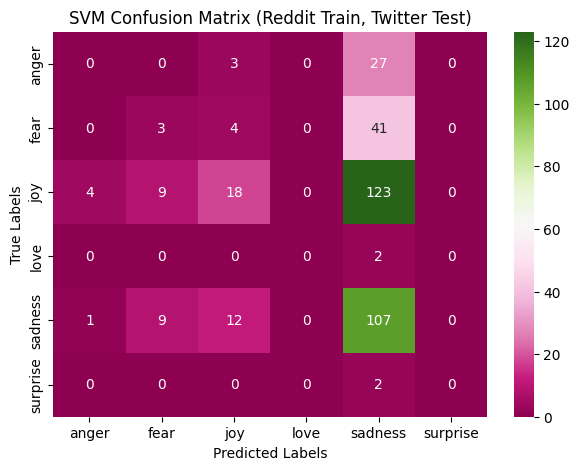

In [ ]:
# Compute confusion matrix for Reddit train and Twitter test
cm_twitter = confusion_matrix(y_twitter_test, y_twitter_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm_twitter, annot=True, fmt='d', cmap='PiYG', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('SVM Confusion Matrix (Reddit Train, Twitter Test)')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
